In [1]:
import cv2
import imgaug
from imgaug import augmenters
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from bs4 import BeautifulSoup
import os
import matplotlib.pyplot as plt

In [2]:
%matplotlib_inline

UsageError: Line magic function `%matplotlib_inline` not found.


In [3]:
imgaug.seed(1)

In [ ]:
""" seq_augmentations = augmenters.Sequential([
    augmenters.Crop(px=(0,16)),     # crop images from each side by 0 to 16px (randomly chosen)
    augmenters.Fliplr(0.5)           # horizontally flip 50% of the images
    augmenters.GaussianBlur(sigma=(0,3.0))  # blur images with a sigma of 0 to 3.0
]) """

In [5]:
def read_xml(file_name):
    file = open(file_name,'r')
    contents = file.read()
    soup = BeautifulSoup(contents, 'xml')
    folder = soup.find('folder').get_text()
    filename = soup.find('filename').get_text()
    path = soup.find('path').get_text()
    width = soup.find('width').get_text()
    height = soup.find('height').get_text()
    depth = soup.find('depth').get_text()
    segmented = soup.find('segmented').get_text()
    objects = soup.find_all('object')
    return folder, filename, path, width, height, depth, segmented, objects


In [10]:

folder, filename, path, width, height, depth, segmented, objects = read_xml('./dataset/annotations/1007.xml')

In [ ]:

# Test Code
 
""" rect = []
def extract_coordinates(bndbox):
    coordinates = []
    for coordinate in bndbox:
        coordinates.append(coordinate)
    return coordinates
        

for object in objects:
    name = object.find('name').get_text()
    pose = object.find('pose').get_text()
    truncated = object.find('truncated').get_text()
    difficult = object.find('difficult').get_text()
    bndbox = object.find('bndbox').get_text()
    coordinates = extract_coordinates(bndbox)
    rect.append(coordinates)
print(rect)

bbox =[]
for idx, point in enumerate(rect):
    point_in_str = "".join(point)
    temp = point_in_str.split('\n')
    bbox.append([int(coordinate) for coordinate in temp[1:-1]])
bbox """

In [11]:
# Extracting all the coordinates of bounding boxes
rects = []
bbox =[]
def bbox_in_char(bndbox):
    coordinates = []
    for str in bndbox:
        coordinates.append(str)
    return coordinates


def extract_coordinates(rect):
    rect_in_str = "".join(rect)
    rect = rect_in_str.split('\n')
    return [int(coordinate) for coordinate in rect[1:-1]]
    
        

for object in objects:
    name = object.find('name').get_text()
    pose = object.find('pose').get_text()
    truncated = object.find('truncated').get_text()
    difficult = object.find('difficult').get_text()
    bndbox = object.find('bndbox').get_text()
    coordinates = bbox_in_char(bndbox)
    bbox.append([name, pose, truncated, difficult, extract_coordinates(coordinates)])


In [12]:
bbox

[['5head', 'Unspecified', '1', '0', [246, 1, 490, 245]],
 ['5tail', 'Unspecified', '1', '0', [1, 2, 244, 245]]]

# BBox are remained to be transformed based on the augmentation on the image

In [13]:
# read image
image = cv2.imread('./dataset/images/1007.jpg')

In [14]:
# read bounding boxes
bbs_lst = []
for val in bbox:
    #print(val[4][1])
    bbs_lst.append(BoundingBox(x1=val[4][0], y1=val[4][1], x2=val[4][2], y2=val[4][2]))

bbs = BoundingBoxesOnImage(bbs_lst, shape=image.shape)

In [25]:
transformations = augmenters.Sequential([
    augmenters.Multiply((0.2, 1.1)),
    augmenters.Affine(
        translate_px={'x':40, 'y':60},
        scale=(0.5, 0.7)
    )
])

In [26]:
img_augmented, bbs_augmented = transformations(image=image, bounding_boxes=bbs)

In [27]:
cv2.imwrite('transfored_image.jpg',img_augmented)

True

In [28]:
for i in range(len(bbs.bounding_boxes)):
    before = bbs.bounding_boxes[i]
    after = bbs_augmented.bounding_boxes[i]
    print(before)
    print("BB %d: (%.4f, %.4f, %.4f, %.4f) -> (%s, %s, %s, %s)" % (
        i,
        before.x1, before.y1, before.x2, before.y2,
        int(after.x1), int(after.y1), int(after.x2), after.y2
    ))

BoundingBox(x1=246.0000, y1=1.0000, x2=490.0000, y2=490.0000, label=None)
BB 0: (246.0000, 1.0000, 490.0000, 490.0000) -> (285, 119, 412, 373.1677)
BoundingBox(x1=1.0000, y1=2.0000, x2=244.0000, y2=244.0000, label=None)
BB 1: (1.0000, 2.0000, 244.0000, 244.0000) -> (158, 119, 284, 245.53708)


In [29]:
def float_coordinates_to_int(bbox):
    x1 = int(round(bbox.x1, 0))
    y1 = int(round(bbox.y1, 0))
    x2 = int(round(bbox.x2, 0))
    y2 = int(round(bbox.y2, 0))
    bbox = BoundingBox(x1, y1, x2, y2)
    return bbox

0
1


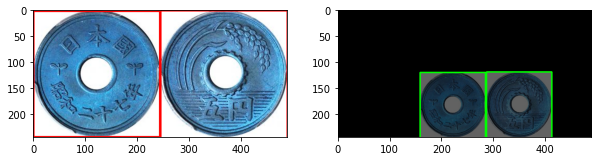

In [30]:
for i in range(len(bbs.bounding_boxes)):
    print(i)
    before = bbs.bounding_boxes[i]
    before = float_coordinates_to_int(before)
    image_before = cv2.rectangle(image, (before.x1, before.y1), (before.x2, before.y2), (255,0,0), 2)

    after = bbs_augmented.bounding_boxes[i]
    after = float_coordinates_to_int(after)
    image_after = cv2.rectangle(img_augmented, (after.x1, after.y1), (after.x2, after.y2), (0,255,0), 2)

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(image_before)

ax2 = fig.add_subplot(1,2,2)
ax2.imshow(image_after)

# Writing XML files

In [31]:
import xml.etree.ElementTree as ET
from xml.dom import minidom

In [ ]:
# TEST CODE
parent_root = ET.Element('annotation')
element_1 = ET.SubElement(parent_root, 'filename')
element_2 = ET.SubElement(parent_root, 'object')
element_1.text = '1007_1.xml'
element_2.text = 'coordinateiiiiiiiiiiii values'

xml_str = minidom.parseString(ET.tostring(parent_root))
pretty_xml = xml_str.toprettyxml(indent="\t")
print(ET.tostring(parent_root))

with open('1007_1.xml', 'w') as f:
    f.write(pretty_xml)

In [ ]:
parent_root = ET.Element('annotation')

element_folder = ET.SubElement(parent_root, 'folder')
element_folder.text = folder

element_filename = ET.SubElement(parent_root, 'filename')
element_filename.text = filename

element_path = ET.SubElement(parent_root, 'path')
element_path.text = path

element_source = ET.SubElement(parent_root, 'source')
subelement_database = ET.SubElement(element_source, 'database')
subelement_database.text = 'Unknown'

element_size = ET.SubElement(parent_root, 'size')
subelement_width = ET.SubElement(element_size, 'width')
subelement_width.text = width

subelement_height = ET.SubElement(element_size, 'height')
subelement_height.text = height

subelement_depth = ET.SubElement(element_size, 'depth')
subelement_depth.text = depth

element_segmented = ET.SubElement(parent_root, 'segmented')
element_segmented.text = segmented

for box in bbox:
    element_object = ET.SubElement(parent_root, 'object')

    subelement_name = ET.SubElement(element_object, 'name')
    subelement_name.text = box[0]

    subelement_pose = ET.SubElement(element_object, 'pose')
    subelement_pose.text = box[1]

    subelement_truncated = ET.SubElement(element_object, 'truncated')
    subelement_truncated.text = box[2]

    subelement_difficult = ET.SubElement(element_object, 'difficult')
    subelement_difficult.text = box[3]

    subelement_bndbox = ET.SubElement(element_object, 'bndbox')

    childelement_xmin = ET.SubElement(subelement_bndbox, 'xmin')
    childelement_xmin.text = str(box[4][0])

    childelement_ymin = ET.SubElement(subelement_bndbox, 'ymin')
    childelement_ymin.text = str(box[4][1])

    childelement_xmax = ET.SubElement(subelement_bndbox, 'xmax')
    childelement_xmax.text = str(box[4][2])

    childelement_ymax = ET.SubElement(subelement_bndbox, 'ymax')
    childelement_ymax.text = str(box[4][3])


xml_str = minidom.parseString(ET.tostring(parent_root))
pretty_xml = xml_str.toprettyxml(indent="\t")
print(ET.tostring(parent_root))

with open('1007_2.xml', 'w') as f:
    f.write(pretty_xml)

In [32]:
def write_xml(folder, filename, path, width, height, depth, segmented, bbox):
    parent_root = ET.Element('annotation')

    element_folder = ET.SubElement(parent_root, 'folder')
    element_folder.text = folder

    element_filename = ET.SubElement(parent_root, 'filename')
    element_filename.text = filename

    element_path = ET.SubElement(parent_root, 'path')
    element_path.text = path

    element_source = ET.SubElement(parent_root, 'source')
    subelement_database = ET.SubElement(element_source, 'database')
    subelement_database.text = 'Unknown'

    element_size = ET.SubElement(parent_root, 'size')
    subelement_width = ET.SubElement(element_size, 'width')
    subelement_width.text = width

    subelement_height = ET.SubElement(element_size, 'height')
    subelement_height.text = height

    subelement_depth = ET.SubElement(element_size, 'depth')
    subelement_depth.text = depth

    element_segmented = ET.SubElement(parent_root, 'segmented')
    element_segmented.text = segmented

    for box in bbox:
        element_object = ET.SubElement(parent_root, 'object')

        subelement_name = ET.SubElement(element_object, 'name')
        subelement_name.text = box[0]

        subelement_pose = ET.SubElement(element_object, 'pose')
        subelement_pose.text = box[1]

        subelement_truncated = ET.SubElement(element_object, 'truncated')
        subelement_truncated.text = box[2]

        subelement_difficult = ET.SubElement(element_object, 'difficult')
        subelement_difficult.text = box[3]

        subelement_bndbox = ET.SubElement(element_object, 'bndbox')

        childelement_xmin = ET.SubElement(subelement_bndbox, 'xmin')
        childelement_xmin.text = str(box[4][0])

        childelement_ymin = ET.SubElement(subelement_bndbox, 'ymin')
        childelement_ymin.text = str(box[4][1])

        childelement_xmax = ET.SubElement(subelement_bndbox, 'xmax')
        childelement_xmax.text = str(box[4][2])

        childelement_ymax = ET.SubElement(subelement_bndbox, 'ymax')
        childelement_ymax.text = str(box[4][3])


    xml_str = minidom.parseString(ET.tostring(parent_root))
    pretty_xml = xml_str.toprettyxml(indent="\t")
    print(ET.tostring(parent_root))

    filename = filename.split('.')[0]
    with open(filename + '.xml', 'w') as f:
        f.write(pretty_xml)

In [33]:
# Update filename, and path
filename_prefix = filename.split('.')
filename_new = filename_prefix[0] + '_copy1.' + filename_prefix[-1]

path_new = os.path.join(('\\').join(path.split('\\')[:-1]), filename_new)

In [34]:
write_xml(folder, filename_new, path_new, width, height, depth, segmented, bbox)

b'<annotation><folder>5</folder><filename>1007_copy1.jpg</filename><path>D:\\dataset\\coin\\v1\\images\\5\\1007_copy1.jpg</path><source><database>Unknown</database></source><size><width>490</width><height>245</height><depth>3</depth></size><segmented>0</segmented><object><name>5head</name><pose>Unspecified</pose><truncated>1</truncated><difficult>0</difficult><bndbox><xmin>246</xmin><ymin>1</ymin><xmax>490</xmax><ymax>245</ymax></bndbox></object><object><name>5tail</name><pose>Unspecified</pose><truncated>1</truncated><difficult>0</difficult><bndbox><xmin>1</xmin><ymin>2</ymin><xmax>244</xmax><ymax>245</ymax></bndbox></object></annotation>'
